In [153]:
#Import package
import pandas as pd
import numpy as np

In [2]:
# Import corrected Excel files
# I resave all excel files into xlsx
# and I seprate the file into column directly into excell
# Take 7 min

Interventions_df = pd.read_excel('InterventionsV2.xlsx')
aed_df = pd.read_excel('aedV2.xlsx')
BrusselsInterventions_df = pd.read_excel('BrusselsInterventionsV2.xlsx')
ambulances_df = pd.read_excel('ambulancesV2.xlsx')

print(Interventions_df.head(5))
print(aed_df.head(5))
print(BrusselsInterventions_df.head(5))
print(ambulances_df.head(5))

    Mission ID                 Service Name  PostalCode permanence  \
0  10221520001     HA UR MECH AZ St Maarten                 2800.0   
1  10221520002               BA KAPE AMBUCE                 2950.0   
2  10221520002       HA UR ANTW Stuivenberg                 2060.0   
3  10221520004  BA ANTW [Borgerhout] AMBUCE                 2140.0   
4  10221520005               BA WIJN AMBUCE                 2110.0   

      CityName permanence Permanent_municipality   StreetName permanence  \
0     Mechelen (Mechelen)               Mechelen          Liersesteenweg   
1     Kapellen (Kapellen)               Kapellen         Essenhoutstraat   
2   Antwerpen (Antwerpen)              Antwerpen  Lange Beeldekensstraat   
3  Antwerpen (Borgerhout)              Antwerpen           Gijselsstraat   
4     Wijnegem (Wijnegem)               Wijnegem           Bijkhoevelaan   

  HouseNumber permanence  Latitude permanence  Longitude permanence  \
0                    NaN            51.051020      

In [5]:
# EXAMPLE :
# Convert adress to latitude and longitude
# using geopy library and Nominatim class

from geopy.geocoders import Nominatim
# calling the Nominatim tool and create Nominatim class
loc = Nominatim(user_agent="Geopy Library")
# entering the location name
getLoc = loc.geocode("İzmir")
# printing address
print(getLoc.address)
# printing latitude and longitude
print("Latitude = ", getLoc.latitude, "\n")
print("Longitude = ", getLoc.longitude)

İzmir, Ege Bölgesi, Türkiye
Latitude =  38.23166 

Longitude =  27.02997


In [6]:
# CLEANING AND ADJUSTING AED DATAFRAME

# 1. Clean wierd characters

aedClean_df = aed_df
column_names = list(aedClean_df.columns.values)
# print(column_names)
for name in column_names:
    if isinstance(aedClean_df[name][1], str): #not robust if value of row 1 is missing!
        print(name)
        aedClean_df[name] = aedClean_df[name].str.replace('Ã¨','è')
        aedClean_df[name] = aedClean_df[name].str.replace('Ã©','é')
        aedClean_df[name] = aedClean_df[name].str.replace('Ã§','ç')
        aedClean_df[name] = aedClean_df[name].str.replace('Ã´','ô')
        aedClean_df[name] = aedClean_df[name].str.replace('Av.','Avenue')
        aedClean_df[name] = aedClean_df[name].str.replace('Bd.','Boulevard')
        aedClean_df[name] = aedClean_df[name].str.replace('Blvd.','Boulevard')
        # TD/ add blvd -> boulvard, av -> avenue

#  2. Add numberStr column which return string format of th einteger of the street number
import math

def streetnumber(number):
    if not math.isnan(number):
        newnumber = str(int(number))
    else:
        newnumber = ''
    return newnumber

aedClean_df['numberStr'] = aedClean_df['number'].apply(streetnumber)
aedClean_df.head(5)


address
Region
Province
Arrondissement
Municipality


,id,type,address,number,Region,Province,Arrondissement,Municipality,type.1,postal_code,public,available,hours,numberStr
0,13.0,NaN,Boulevard Fr. Roosevelt,24.0,Wallonia,Hainaut (le),Soignies,Soignies,NaN,7060.0,Yes,NaN,NaN,24
1,70.0,NaN,Ch. De Wégimont,76.0,Wallonia,Liège,Liège,Soumagne,NaN,4630.0,NaN,NaN,NaN,76
2,70.0,NaN,Ch. De Wégimont,76.0,Wallonia,Liège,Liège,Soumagne,NaN,4630.0,NaN,NaN,NaN,76
3,71.0,NaN,Place Saint - Lambert,NaN,Wallonia,Liège,Liège,Liège,NaN,4020.0,NaN,NaN,NaN,
4,72.0,NaN,Rue Du Doyard,NaN,Wallonia,Liège,Verviers,Lierneux,NaN,4990.0,NaN,NaN,NaN,


In [7]:
# ADD LOCATION COORDONATE TO AED DATAFRAME
# using geopy library and Nominatim class object
# NOTE: It took a long time to run (1~2 hours) due to high number of AEDs
# Good practice to save dataframe into table !
from geopy.geocoders import Nominatim

def locationBE(numberStr, address, Arrondissement):
    try:
        geolocator = Nominatim(user_agent="my_user_agent")
        street = numberStr+' '+address
        city = Arrondissement
        country = 'Belgique'
        loc = geolocator.geocode(street+','+city+','+ country, timeout=120)
        return loc.latitude,loc.longitude
    except:
        return float('nan'),float('nan')

# Testing locationBE function
# lat,lon = locationBE('1','Albert Leemansplein','Bruxelles')
# print(lat)

In [8]:
# Applying on a subset, waiting for the new table to be created

aedsubset_df = aedClean_df.head(100)
aedsubset_df['Location'] = aedsubset_df.apply(lambda x: locationBE(x['numberStr'], x['address'], x['Arrondissement']), axis=1)
aedsubset_df['Location'].head(5)

C:\Users\Ramy\AppData\Local\Temp\ipykernel_17224\3463772353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aedsubset_df['Location'] = aedsubset_df.apply(lambda x: locationBE(x['numberStr'], x['address'], x['Arrondissement']), axis=1)


0                 (nan, nan)
1                 (nan, nan)
2                 (nan, nan)
3    (50.6451853, 5.5742929)
4    (50.2856407, 5.7808696)
Name: Location, dtype: object

In [8]:
# Some statistics

def mean_speed(time, distance):
    speed = distance/time
    return speed

# To show more row in notebook
pd.options.display.max_rows = 4000

Interventions_smalldf=Interventions_df.head(2000)
i = Interventions_smalldf[Interventions_smalldf['Calculated travelTime destinatio'] == 0.0].index
Interventions_smalldf = Interventions_smalldf.drop(i)
Interventions_smalldf['mean_speed']=Interventions_smalldf.apply(lambda x: mean_speed(x['Calculated travelTime destinatio'], x['Calculated Distance destination']), axis=1)
# print(Interventions_smalldf['mean_speed'])

# print(Interventions_smalldf['mean_speed'].mean())
import matplotlib
# print(Interventions_smalldf['mean_speed'].hist())
Key = ['EventLevel Firstcall']
# print(Interventions_smalldf.groupby(Key)['mean_speed'].mean())

Key = ['EventLevel Firstcall','EventType Trip']
print(Interventions_smalldf.groupby(Key)['mean_speed'].mean())
# Key = ['EventType Trip']
# print(Interventions_smalldf.groupby(Key)['mean_speed'].mean())

EventLevel Firstcall  EventType Trip                                              
N0                    P003 - Cardiac arrest                                           15.671830
                      P004 - Stroke                                                   10.880682
                      P010 - Respiratory problems                                     11.465116
                      P019 - Unconscious - syncope                                          NaN
N1                    P001 - Traffic accident                                         18.405085
                      P002 - Agression - fight - rape                                       NaN
                      P003 - Cardiac arrest                                           14.727487
                      P004 - Stroke                                                   17.157534
                      P006 - Burns                                                    25.699793
                      P007 - Fall from great height (

In [42]:
# Nearest Neighbour
# 1. Clean a bit more ambulance dataframe
ambulances_df.head(10)
amb_df = ambulances_df[['base','latitude','longitude','Arrondissement']]
# Create a Tuple 'coordonate' from latitude and longitude
amb_df['coordonate'] = list(zip(amb_df.latitude, amb_df.longitude))
amb_df['coordonate'].head(10)
amb_df.head(10)

from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# 2. Create a list of coordonate (amb_list) 
# and a Mulitpoint of coordonate (departures)
# for Nearest Neighbour method
amb_list = amb_df['coordonate'].tolist()
departures= MultiPoint(amb_list)
# print(departures)

# Make to coordonate Tuple into Point
amb_df['PointCoordonate'] = amb_df.apply(lambda x: Point(x['latitude'], x['longitude']), axis=1)
print(amb_df['PointCoordonate'].head(10))

# Test
testpoint = Point(50.5641805, 4.4907038)
amb_df.loc[amb_df['PointCoordonate'] == testpoint]
# print((testpoint.x,testpoint.y))

# # EXAMPLE NN method
# orig = Point(50.5,4.5)
# nearest_depart = nearest_points(orig, departures)
# near_idx0 = nearest_depart[0]
# near_idx1 = nearest_depart[1]
# print(nearest_depart)
# print(near_idx0)
# print(near_idx1)

# Adding new ambulance to the list of departures
# departures.append([Point(newCoordonate)])

0    POINT (51.2155158 4.4437875)
1    POINT (51.1788314 4.3619482)
2     POINT (51.2328096 4.377237)
3    POINT (51.3155156 4.3215063)
4    POINT (51.2136226 4.4057177)
5      POINT (51.319819 5.089912)
6    POINT (51.3209834 4.8566561)
7    POINT (51.1140555 4.6472462)
8    POINT (51.4646726 4.4725507)
9     POINT (51.0430641 4.815907)
Name: PointCoordonate, dtype: object


C:\Users\Ramy\AppData\Local\Temp\ipykernel_17224\1016536907.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amb_df['coordonate'] = list(zip(amb_df.latitude, amb_df.longitude))
C:\Users\Ramy\AppData\Local\Temp\ipykernel_17224\1016536907.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amb_df['PointCoordonate'] = amb_df.apply(lambda x: Point(x['latitude'], x['longitude']), axis=1)


,base,latitude,longitude,Arrondissement,coordonate,PointCoordonate
277,BF SART BHN AMBU,50.56418,4.490704,Nivelles,"(50.5641805, 4.4907038)",POINT (50.5641805 4.4907038)


In [113]:
#AED multipoint
# Take more than 1 hour
aedClean_df['Latitude','Longitude'] = aedClean_df.apply(lambda x: locationBE(x['numberStr'], x['address'], x['Arrondissement']), axis=1)
aedOK_df = aedClean_df[['numberStr','address','Arrondissement','Latitude','Longitude']]

In [21]:
#P003 (cardiac arrest) dataFrame from interventions
Interventions_df['EventType Trip'].head(5)
P003_df = Interventions_df[Interventions_df['EventType Trip'] == 'P003 - Cardiac arrest']
P003_df.head(5)
# P003_df.to_csv('P003.csv', index=False)

,Mission ID,Service Name,PostalCode permanence,CityName permanence,Permanent_municipality,StreetName permanence,HouseNumber permanence,Latitude permanence,Longitude permanence,Permanence short name,...,Latitude intervention,Longitude intervention,Waiting time,Name destination hospital,PostalCode destination hospital,CityName destination hospital,HouseNumber destination hospital,Hospital_municipality,Calculated travelTime destinatio,Calculated Distance destination
42,10221520047,HA UR GEEL AZ St Dimpna,2440.0,Geel (Geel),Geel,J.B.-Stessensstraat,NaN,51.16013,4.99975,UAGEEL01A,...,51.20685,5.13662,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,10221520095,BA ANTW [Kaai 606] SIHWA,2040.0,Antwerpen (Albertdok),Antwerpen,Antwerpsebaan,NaN,51.31287,4.32425,AAAPOR02A,...,51.24848,4.43869,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,10221520095,HA UR ANTW Stuivenberg,2060.0,Antwerpen (Antwerpen),Antwerpen,Lange Beeldekensstraat,NaN,51.22249,4.43629,UAANTW01A,...,51.24848,4.43869,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,10221520224,HA UR ANTW Stuivenberg,2060.0,Antwerpen (Antwerpen),Antwerpen,Lange Beeldekensstraat,NaN,51.22249,4.43629,UAANTW01A,...,51.28273,4.42134,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,10221520224,HA UR ANTW Jan Palfijn,2170.0,Antwerpen (Merksem),Antwerpen,Lange Bremstraat,NaN,51.25783,4.45277,AAANTW10A,...,51.28273,4.42134,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
BrusselsInterventions_df.head(5)
# TD, obtain event type in brussels

,mission_id,postalcode_permanence,cityname_permanence,streetname_permanence,housenumber_permanence,latitude_permanence,longitude_permanence,postalcode_destination_hospital,cityname_destination_hospital,streetname_destination_hospital,housenumber_destination_hospital,Longitude intervention,Latitude intervention,calculated_traveltime_departure_,calculated_distance_departure_to,calculated_traveltime_destinatio,calculated_distance_destination_,EventType and EventLevel,Abandon reason FR
0,20222490011,1000,Brussel (Brussel),Vesaliusstraat,NaN,5085097,436411,NaN,NaN,NaN,NaN,NaN,NaN,92.0,784.0,NaN,NaN,NaN,NaN
1,20222490011,1000,Brussel (Brussel),Vesaliusstraat,NaN,5085097,436411,NaN,NaN,NaN,NaN,NaN,NaN,92.0,784.0,NaN,NaN,NaN,NaN
2,20222490011,1000,Brussel (Brussel),Vesaliusstraat,NaN,5085097,436411,NaN,NaN,NaN,NaN,NaN,NaN,92.0,784.0,NaN,NaN,NaN,NaN
3,20222490011,1000,Brussel (Brussel),Vesaliusstraat,NaN,5085097,436411,1000.0,Brussel (Brussel),Broekstraat,NaN,NaN,NaN,92.0,784.0,136.0,1330.0,NaN,NaN
4,20222490011,1000,Brussel (Brussel),Vesaliusstraat,NaN,5085097,436411,1000.0,Brussel (Brussel),Broekstraat,NaN,NaN,NaN,92.0,784.0,136.0,1330.0,NaN,NaN


In [22]:
#P003 travel time
#(in future, depending on city !)
P003_df['Calculated travelTime destinatio'].head(100)



42         NaN
87         NaN
88         NaN
207        NaN
208        NaN
276      312.0
277        NaN
284        NaN
285        NaN
406        NaN
407      216.0
408      216.0
477        NaN
478        NaN
514        NaN
515      595.0
516        NaN
517      273.0
750     1213.0
751        NaN
837        NaN
838        NaN
976        NaN
1071       NaN
1072       NaN
1107       NaN
1108       NaN
1143       NaN
1144     271.0
1371       NaN
1372     526.0
1871       NaN
1872       NaN
1936       NaN
1937       NaN
2354       NaN
2355     138.0
2363       NaN
2364       NaN
2525       NaN
2595       NaN
2596       NaN
2609       NaN
2610       NaN
2640       NaN
2641       NaN
2940       NaN
2941       NaN
3196       NaN
3197       NaN
3215       NaN
3216     151.0
3217       NaN
3305       NaN
3306       NaN
3345     574.0
3346       NaN
3413     197.0
3414       NaN
3429       NaN
3430       NaN
3436       NaN
3437       NaN
3438       NaN
3439     349.0
3537       NaN
3608      

In [ ]:
# TO DO
# AED Location by part OK
# mean travel speed for cardiac arrest OK
# mean intervention time depending on accident location (with CI!)
# Function : chance of survy of cardiac arrest depending on ambulance distance and speed
# if AED close, increase chance of survival
# Map with color indicator of chance of survy depending on location
# Which will change by adding/Removing AED and ambulance departure
# Map show little dot for AED and other little dot for ambulance departure

# BONUS: optimization
# given a number of DEA and ambulance, function that optimize survival chance
# based on density of population/number of cardiac arrest (more DEA/ambulance in city)

In [ ]:
#Measuring Distance by geopy library

# from geopy.distance import geodesic
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(geodesic(newport_ri, cleveland_oh).miles)

# from geopy.distance import great_circle
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(great_circle(newport_ri, cleveland_oh).miles)


In [18]:
# Function Distance parcoure
# print(P003_df.head(5))

from geopy.distance import geodesic
def dist(Lat_per,Lon_per, lat_desti, long_desti):
    #lat_per = latitude permance
    #lat_desti = latitude destination
    # print(geodesic((Lat_per,Lon_per), (lat_desti, long_desti)).km)
    # print(geodesic((Lat_per,Lon_per), (lat_desti, long_desti)))
    dist_km = geodesic((Lat_per,Lon_per), (lat_desti, long_desti)).km
    return dist_km

dist(51.16013,4.99975,51.20685,5.13662)


10.890406723068589

In [25]:
# Function Time traveled
P003_df.head(5)
# Need time from T0 to T3
# There is no T0, so T1 to T3


,Mission ID,Service Name,PostalCode permanence,CityName permanence,Permanent_municipality,StreetName permanence,HouseNumber permanence,Latitude permanence,Longitude permanence,Permanence short name,...,Latitude intervention,Longitude intervention,Waiting time,Name destination hospital,PostalCode destination hospital,CityName destination hospital,HouseNumber destination hospital,Hospital_municipality,Calculated travelTime destinatio,Calculated Distance destination
42,10221520047,HA UR GEEL AZ St Dimpna,2440.0,Geel (Geel),Geel,J.B.-Stessensstraat,NaN,51.16013,4.99975,UAGEEL01A,...,51.20685,5.13662,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,10221520095,BA ANTW [Kaai 606] SIHWA,2040.0,Antwerpen (Albertdok),Antwerpen,Antwerpsebaan,NaN,51.31287,4.32425,AAAPOR02A,...,51.24848,4.43869,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,10221520095,HA UR ANTW Stuivenberg,2060.0,Antwerpen (Antwerpen),Antwerpen,Lange Beeldekensstraat,NaN,51.22249,4.43629,UAANTW01A,...,51.24848,4.43869,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,10221520224,HA UR ANTW Stuivenberg,2060.0,Antwerpen (Antwerpen),Antwerpen,Lange Beeldekensstraat,NaN,51.22249,4.43629,UAANTW01A,...,51.28273,4.42134,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,10221520224,HA UR ANTW Jan Palfijn,2170.0,Antwerpen (Merksem),Antwerpen,Lange Bremstraat,NaN,51.25783,4.45277,AAANTW10A,...,51.28273,4.42134,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#AED multipoint
max = 16600 #then do the last 68
n = 166

for i in range(1, 45):
    aedpart_df=aedClean_df.loc[(i*166):(i+1)*166]
    aedpart_df['Latitude','Longitude'] = aedpart_df.apply(lambda x: locationBE(x['numberStr'], x['address'], x['Arrondissement']), axis=1)
    # aedOK_df = aedClean_df[['numberStr','address','Arrondissement','Latitude','Longitude']]
    aedpart_df.to_csv('aedOK'+str(i)+'.csv', index=False)

# There is an issue with data from head(42 to 44)
for i in range(45, 166):
    aedpart_df=aedClean_df.loc[(i*166):(i+1)*166]
    aedpart_df['Latitude','Longitude'] = aedpart_df.apply(lambda x: locationBE(x['numberStr'], x['address'], x['Arrondissement']), axis=1)
    # aedOK_df = aedClean_df[['numberStr','address','Arrondissement','Latitude','Longitude']]
    aedpart_df.to_csv('aedOK'+str(i)+'.csv', index=False)

In [4]:
aedOK1_df = pd.read_csv('aedOK1.csv', sep=',')
aedOK1_df.head(10)

,id,type,address,number,Region,Province,Arrondissement,Municipality,type.1,postal_code,public,available,hours,numberStr,"('Latitude', 'Longitude')"
0,461.0,NaN,Kruisstraat,54.0,Flanders,Vlaams-Brabant,Leuven,Tremelo,NaN,3120.0,NaN,NaN,NaN,54.0,"(50.87884655, 4.550640250000001)"
1,466.0,NaN,Avenue De Burlet,4.0,Wallonia,Brabant wallon (le),Nivelles,Nivelles,NaN,1400.0,NaN,NaN,NaN,4.0,"(50.6021621, 4.334147927342322)"
2,468.0,NaN,Zeypestraat,26.0,Flanders,Vlaams-Brabant,Halle-Vilvoorde,Kampenhout,NaN,1910.0,Yes,NaN,NaN,26.0,"(50.805841799999996, 4.23626046456244)"
3,469.0,NaN,Bergtorfbroeklaan,NaN,Flanders,Vlaams-Brabant,Halle-Vilvoorde,Kampenhout,NaN,1910.0,Yes,NaN,NaN,NaN,"(nan, nan)"
4,470.0,NaN,Kerkstraat,34.0,Flanders,Vlaams-Brabant,Halle-Vilvoorde,Kampenhout,NaN,1910.0,Yes,NaN,NaN,34.0,"(50.872310549999995, 4.157228485994391)"
5,471.0,NaN,Steenweg Op Zevendonk,18.0,Flanders,Antwerpen,Turnhout,Turnhout,NaN,2300.0,Yes,NaN,NaN,18.0,"(51.3084446, 4.9479040730835955)"
6,472.0,NaN,Uilenbaan,15.0,Flanders,Antwerpen,Antwerpen,Wommelgem,NaN,2160.0,NaN,NaN,NaN,15.0,"(51.21313845, 4.502395060372304)"
7,473.0,NaN,Reep,1.0,Flanders,Oost-Vlaanderen,Gent,Gent,NaN,9000.0,Yes,NaN,NaN,1.0,"(51.16995285, 3.862265646006946)"
8,474.0,NaN,Vlamingenstraat,83.0,Flanders,Vlaams-Brabant,Leuven,Leuven,NaN,3000.0,Yes,NaN,NaN,83.0,"(50.87427295, 4.7017900856514245)"
9,474.0,NaN,Vlamingenstraat,83.0,Flanders,Vlaams-Brabant,Leuven,Leuven,NaN,3000.0,Yes,NaN,NaN,83.0,"(50.87427295, 4.7017900856514245)"


In [101]:
aed_list = []
# exec("aedOKK_df = pd.read_csv('aedOK0.csv', sep=',')")
# eval("aedOKK"+str(1)+"_df = pd.read_csv('aedOK"+str(1)+".csv', sep=',')")
for i in range(106): #I remove the 165 because
    if i >= 42 and i <=44:
        continue
    else:
        exec("aedOK"+str(i)+"_df = pd.read_csv('aedOK"+str(i)+".csv', sep=',')")
        eval("aed_list.append(aedOK"+str(i)+"_df)")
len_aed_lst = len(aed_list)
# print(aed_list[0].columns)
# print(aed_list[0].head(5))
aedCoordonate = pd.concat(aed_list)#, columns=aed_list[1].columns)
# eval("")
# len(aed_list)
# aed_list[0].dtypes


In [146]:
aedCoordonate.head(10)

,id,type,address,number,Region,Province,Arrondissement,Municipality,type.1,postal_code,public,available,hours,numberStr,"('Latitude', 'Longitude')",Latitude,Longitude,coordonate
0,13.0,NaN,Boulevard Fr. Roosevelt,24.0,Wallonia,Hainaut (le),Soignies,Soignies,NaN,7060.0,Yes,NaN,NaN,24.0,"(nan, nan)",NaN,NaN,"(nan, nan)"
1,70.0,NaN,Ch. De Wégimont,76.0,Wallonia,Liège,Liège,Soumagne,NaN,4630.0,NaN,NaN,NaN,76.0,"(nan, nan)",NaN,NaN,"(nan, nan)"
2,70.0,NaN,Ch. De Wégimont,76.0,Wallonia,Liège,Liège,Soumagne,NaN,4630.0,NaN,NaN,NaN,76.0,"(nan, nan)",NaN,NaN,"(nan, nan)"
3,71.0,NaN,Place Saint - Lambert,NaN,Wallonia,Liège,Liège,Liège,NaN,4020.0,NaN,NaN,NaN,NaN,"(50.6451853, 5.5742929)",50.645185,5.574293,"(50.6451853, 5.5742929)"
4,72.0,NaN,Rue Du Doyard,NaN,Wallonia,Liège,Verviers,Lierneux,NaN,4990.0,NaN,NaN,NaN,NaN,"(50.2856407, 5.7808696)",50.285641,5.780870,"(50.2856407, 5.7808696)"
5,73.0,NaN,Fond Saint Servais,NaN,Wallonia,Liège,Liège,Liège,NaN,4000.0,NaN,NaN,NaN,NaN,"(50.647276000000005, 5.570219402542373)",50.647276,5.570219,"(50.647276000000005, 5.570219402542373)"
6,73.0,NaN,Fond Saint Servais,NaN,Wallonia,Liège,Liège,Liège,NaN,4000.0,NaN,NaN,NaN,NaN,"(50.647276000000005, 5.570219402542373)",50.647276,5.570219,"(50.647276000000005, 5.570219402542373)"
7,74.0,NaN,Rue Des Prémontrès,12.0,Wallonia,Liège,Liège,Liège,NaN,4020.0,NaN,NaN,NaN,12.0,"(50.6380469, 5.5740461)",50.638047,5.574046,"(50.6380469, 5.5740461)"
8,75.0,NaN,Route De Bastogne,1.0,Wallonia,Liège,Liège,Aywaille,NaN,4920.0,NaN,NaN,NaN,1.0,"(50.3806158, 5.680907587084247)",50.380616,5.680908,"(50.3806158, 5.680907587084247)"
9,76.0,NaN,Rue Du Parc,1.0,Wallonia,Liège,Huy,Amay,NaN,4540.0,NaN,NaN,NaN,1.0,"(50.44500025, 5.261918856333335)",50.445000,5.261919,"(50.44500025, 5.261918856333335)"


In [144]:
#TODO
aedCoordonate.columns

def latitude_AED(coordonate_string):
    coord_str = coordonate_string.replace('(','')
    coord_str = coord_str.replace(')','')
    latitude, longitude = coord_str.split(',')
    if latitude=='nan':
        latitude_float = float('nan')
    else:
        latitude_float = float(latitude)
    # longitude_float = float(longitude)
    return latitude_float

def longitude_AED(coordonate_string):
    coord_str = coordonate_string.replace('(','')
    coord_str = coord_str.replace(')','')
    latitude, longitude = coord_str.split(',')
    # latitude_float = float(latitude)
    longitude_float = float(longitude)
    return longitude_float

aedCoordonate['Latitude']  = aedCoordonate.apply(lambda x:  latitude_AED(x["('Latitude', 'Longitude')"]), axis=1)
aedCoordonate['Longitude'] = aedCoordonate.apply(lambda x: longitude_AED(x["('Latitude', 'Longitude')"]), axis=1)

aedCoordonate['Longitude'].head()


0         NaN
1         NaN
2         NaN
3    5.574293
4    5.780870
Name: Longitude, dtype: float64

In [162]:
pd.options.display.max_rows = 4000
# aedCoordonate.head(1000)
print(aedCoordonate.columns)
aedLocation_df=aedCoordonate[['id','Latitude','Longitude']]
aedLocation_df = aedLocation_df.dropna(how='any')
# aedLocation_df.head(5)

aedLocation_df['coordonate'] = list(zip(aedLocation_df.Latitude, aedLocation_df.Longitude))
# print(aedLocation_df['coordonate'].head(10))
# print(aedLocation_df.head(10))

from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# 2. Create a list of coordonate (AED_list_coord) 
# and a Mulitpoint of coordonate (AED_positions)
# for Nearest Neighbour method
AED_list_coord = aedLocation_df['coordonate'].tolist()
AED_positions = MultiPoint(AED_list_coord)


Index(['id', 'type', 'address', 'number', 'Region', 'Province',
       'Arrondissement', 'Municipality', 'type.1', 'postal_code', 'public',
       'available', 'hours', 'numberStr', '('Latitude', 'Longitude')',
       'Latitude', 'Longitude', 'coordonate'],
      dtype='object')


In [137]:
aedCoordonate['coordonate'] = list(zip(aedCoordonate.Latitude, aedCoordonate.Longitude))
print(aedCoordonate['coordonate'].head(10))
aedCoordonate.head(10)

i_Nan = aedCoordonate[aedCoordonate['coordonate'] == '(nan, nan)'].index
print(i_Nan)

from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# 2. Create a list of coordonate (amb_list) 
# and a Mulitpoint of coordonate (departures)
# for Nearest Neighbour method
# AED_list_coord = aedCoordonate['coordonate'].tolist()
# AED_positions = MultiPoint(AED_list_coord)

0                                 (nan, nan)
1                                 (nan, nan)
2                                 (nan, nan)
3                    (50.6451853, 5.5742929)
4                    (50.2856407, 5.7808696)
5    (50.647276000000005, 5.570219402542373)
6    (50.647276000000005, 5.570219402542373)
7                    (50.6380469, 5.5740461)
8            (50.3806158, 5.680907587084247)
9           (50.44500025, 5.261918856333335)
Name: coordonate, dtype: object
Index([], dtype='int64')


In [100]:
aedCoordonate.head(5)

,id,type,address,number,Region,Province,Arrondissement,Municipality,type.1,postal_code,public,available,hours,numberStr,"('Latitude', 'Longitude')",Latitude,Longitude


In [27]:
interventionALL_df = pd.read_csv('Interventions_ALL.csv', sep=',')
interventionALL_df.head()

,Mission ID,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,T0,T1,T2,T3,Arrival duration
0,10221520047,51.16013,4.99975,51.20685,5.13662,2022-06-01 06:45:53,2022-06-01 06:48:30,2022-06-01 06:52:06,2022-06-01 07:04:46,1133.0
1,10221520095,51.31287,4.32425,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:42,2022-06-01 09:30:28,2022-06-01 09:32:29,254.0
2,10221520095,51.22249,4.43629,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:44,2022-06-01 09:35:10,2022-06-01 09:40:51,756.0
3,10221520224,51.22249,4.43629,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:14:47,2022-06-01 15:24:40,805.0
4,10221520224,51.25783,4.45277,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:17:56,2022-06-01 15:47:52,2197.0


In [28]:
# Intevention distance

print(interventionALL_df.dtypes)
interventionALL_df['Permanence coordonate'] = interventionALL_df.apply(lambda x: Point(x['Latitude permanence'], x['Longitude permanence']), axis=1)
print(interventionALL_df['Permanence coordonate'].head(5))
interventionALL_df['Intervention coordonate'] = interventionALL_df.apply(lambda x: Point(x['Latitude intervention'], x['Longitude intervention']), axis=1)
print(interventionALL_df['Intervention coordonate'].head(5))

# Function Distance parcoure
from geopy.distance import geodesic
def dist(Lat_per,Lon_per, lat_desti, long_desti):
    # print(geodesic((Lat_per,Lon_per), (lat_desti, long_desti)).km)
    # print(geodesic((Lat_per,Lon_per), (lat_desti, long_desti)))
    try:
        dist_km = geodesic((Lat_per,Lon_per), (lat_desti, long_desti)).km
    except:
        dist_km = Point(-100.0,-100.0)
    return dist_km

# Or use geodesic directly on coordonate
# dist_km = geodesic(coord_perma, coord_interv).km
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(geodesic(newport_ri, cleveland_oh).miles)

# interventionALL_df['Distance Intervention'] = interventionALL_df.apply(lambda x: geodesic(x['Permanence coordonate'], x['Intervention coordonate']), axis=1)
interventionALL_df['Distance Intervention in km'] = interventionALL_df.apply(lambda x: dist(x['Latitude permanence'], x['Longitude permanence'],x['Latitude intervention'], x['Longitude intervention']), axis=1)

print(interventionALL_df['Distance Intervention in km'].head(5))


Mission ID                  int64
Latitude permanence       float64
Longitude permanence      float64
Latitude intervention     float64
Longitude intervention    float64
T0                         object
T1                         object
T2                         object
T3                         object
Arrival duration          float64
dtype: object
0    POINT (51.16013 4.99975)
1    POINT (51.31287 4.32425)
2    POINT (51.22249 4.43629)
3    POINT (51.22249 4.43629)
4    POINT (51.25783 4.45277)
Name: Permanence coordonate, dtype: object
0    POINT (51.20685 5.13662)
1    POINT (51.24848 4.43869)
2    POINT (51.24848 4.43869)
3    POINT (51.28273 4.42134)
4    POINT (51.28273 4.42134)
Name: Intervention coordonate, dtype: object
0    10.890407
1    10.727319
2     2.896314
3     6.782676
4     3.533465
Name: Distance Intervention in km, dtype: object


c:\Users\Ramy\AppData\Local\Programs\Python\Python39\lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


In [39]:
# Speed per intervention
def speed(distance_km,time_sec):
    try:
        speed_Km_per_sec = distance_km/time_sec
    except:
        speed_Km_per_sec = float("nan")
        # print('Time equal 0')
    return speed_Km_per_sec


interventionALL_df['Speed Km/sec'] = interventionALL_df.apply(lambda x: speed(x['Distance Intervention in km'], x['Arrival duration']), axis=1)
i_nan = interventionALL_df[interventionALL_df['Speed Km/sec'].isna()].index
print(i_nan)
interventionALL_df=interventionALL_df.drop(i_nan)
interventionALL_df['Speed Km/sec'].head(5)

Index([2134, 2211, 2278, 2281, 2398, 2579, 2700, 2706, 2754, 2810,
       ...
       6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024],
      dtype='int64', length=467)


0    0.009612
1    0.042234
2    0.003831
3    0.008426
4    0.001608
Name: Speed Km/sec, dtype: float64

<Axes: >

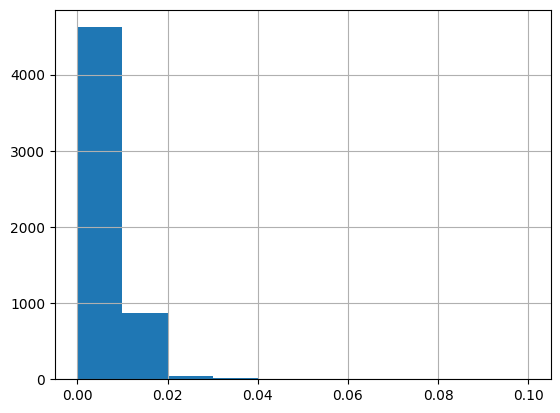

In [238]:
interventionALL_df['Speed Km/sec'].hist()

In [239]:
#Mean speed
mean_speed_kmpsec = interventionALL_df['Speed Km/sec'].mean()
print('vitesse='+str(mean_speed_kmpsec)+'km/sec')
print('vitesse='+str(mean_speed_kmpsec*3600)+'km/h')
mean_speed_kmpsec

vitesse=0.0063516871471603195km/sec
vitesse=22.86607372977715km/h


0.0063516871471603195

In [244]:
def convert_point_to_coordonate(point):
    pstr = str(point)
    pstr = pstr.replace('POINT (','')
    pstr = pstr.replace(')','')
    lat,lon = pstr.split(' ')
    coord = (float(lat),float(lon))
    return coord


def time_for_intervention(coordonate):
    """
    coordonate = coordonate of intervention lcoaiton (Tuple)

    """
    coord_point = Point(coordonate)
    nearest_depart = nearest_points(coord_point, departures)
    coord_amb = convert_point_to_coordonate(nearest_depart[1])
    distance_km = geodesic(coord_amb,coordonate).km
    time_sec = distance_km/mean_speed_kmpsec
    return time_sec

def AED_access(coordonate):
    """
    coordonate = POINT coordonate of intervention lcoaiton

    Check if there is an AED at least than 100 metre
    """
    coord_point = Point(coordonate)
    nearest_AED = nearest_points(coord_point, AED_positions)
    coord_AED = convert_point_to_coordonate(nearest_AED[1])
    distance_AED = geodesic(coord_AED, coordonate).km
    if distance_AED <= 0.1: #less than 100 m
        access = True
    else:
        access = False
    return distance_AED, access

def survival_chance(coordonate):
    """
    coordonate = POINT coordonate of intervention lcoaiton
    """
    time_interv = time_for_intervention(coordonate) #in seconds
    distance_AED, access = AED_access(coordonate) # in km
    human_walk = 5/(3600) # in km/sec (equivalent to 5 km/heure)
    initial_survival = 90 # % chance of survival, see https://sofia.medicalistes.fr/spip/spip.php?article174
    if access:
        time_AED = (distance_AED/human_walk)
        decrease_survival_chance = (time_AED/60)*10
    else:
        # Golden rule
        decrease_survival_chance = (time_interv/60)*10 #minus 10% chance of survive eery 10 minutes
        # survival = (time_interv/60)
    survival = initial_survival - decrease_survival_chance
    if survival <= 0:
        return 0
    else:
        return survival
    # Au-delà de 3 minutes d’arrêt cardiaque, les chances de survies diminuent de 10% chaque minute !
    # Après la crise, chaque minute sans prise en charge diminue de 10% les chances de survie de la victime. 
    # Au-delà de 5 minutes d’arrêt du cœur,les lésions cérébrales sont irréversibles. Au-delà de 12 minutes, c’est la mort
    # Le taux de survie en cas de défibrillation immédiate est de 75%


In [243]:
# print(departures)
p = (51.20685,5.13662)
pp = (51.20685,6)
print(geodesic(p,pp))
ppp = Point(p)
nearest_depart = nearest_points(ppp, departures)
print(nearest_depart[1])
pstr = str(nearest_depart[1])
pstr = pstr.replace('POINT (','')
pstr = pstr.replace(')','')
lat,lon = pstr.split(' ')
coord = (float(lat),float(lon))
print(coord)
# print(ppp)
# time = time_for_intervention(p)
# print(survival_chance(p))
# geodesic(p,nearest_depart[0])


60.337043396054156 km
POINT (51.1889959 5.0948491)
(51.1889959, 5.0948491)


In [275]:
p = (51.20685,5.13662)
pp = (51.20685,6)
ppp = (50.87884655, 4.550640250000001) #AED location
pppp = (50.87884655, 4.5520)
p5 = (51.2155158,4.4437875) #permanence location
p6 = (51.2155158,4.460) #permanence location
time = time_for_intervention(p)
print(time)
print(time/60)
print(AED_access(p))
print(survival_chance(p))

time = time_for_intervention(pp)
print('time in sec: '+str(time))
print('time in sec: '+str(time/60))
print(AED_access(pp))
print(survival_chance(pp))

time = time_for_intervention(ppp)
print('time in sec: '+str(time))
print('time in sec: '+str(time/60))
print(AED_access(ppp))
print(survival_chance(ppp))


time = time_for_intervention(pppp)
print('time in sec: '+str(time))
print('time in sec: '+str(time/60))
print(AED_access(pppp))
print(survival_chance(pppp))

time = time_for_intervention(p5)
print('time in sec: '+str(time))
print('time in sec: '+str(time/60))
print(AED_access(p5))
print(survival_chance(p5))

time = time_for_intervention(p6)
print('time in sec: '+str(time))
print('time in sec: '+str(time/60))
print(AED_access(p6))
print(survival_chance(p6))

555.9655882851791
9.266093138086319
(1.2631658245341033, False)
0
time in sec: 3277.4766708216707
time in sec: 54.62461118036118
(14.177092630770304, False)
0
time in sec: 562.1248975653579
time in sec: 9.368748292755964
(0.0, True)
90.0
time in sec: 577.1122281475535
time in sec: 9.61853713579256
(0.09569965771295105, True)
78.51604107444587
time in sec: 0.0
time in sec: 0.0
(0.13212652165822147, False)
90.0
time in sec: 195.64536223925424
time in sec: 3.260756037320904
(0.3148058505540713, False)
57.39243962679096
